1. 기본적인 feature engineering을 통한 데이터를 이용하여 ml model에 적용하였을 때, 성능을 확인한다(base line)

2. 추후에 eda를 통한 새로운 feature를 추가하면 어떻게 변하는지 살펴보자

3. 2의 결과 성능이 향상되면 hyperparameter tuning까지 기대해볼 수 있다

4. 최종적으로 Stack과 Bagging으로 성능을 끌어올려보자

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

train = pd.read_csv('dataset/train.csv', index_col=0)
test = pd.read_csv('dataset/test.csv', index_col=0)
train.shape, test.shape

((17480, 15), (15081, 14))

# 1. Basic feature engineering

In [2]:
label = set(train.columns) - set(test.columns)
label = ' '.join(label)
label

'target'

In [3]:
def nullCheck(df):
    """ check df and return columns having null value """
    null_columns = []
    for col in df.columns:
        n_null_values = df[col].isnull().sum()
        isNull = True if n_null_values>0 else False
        if isNull:
            print(f'{col} have {n_null_values} na values')
            null_columns.append([col, df[col].dtype])
    if len(null_columns) == 0:
        print('no NA')
    return null_columns

null_cols = nullCheck(train)

workclass have 1836 na values
occupation have 1843 na values
native.country have 583 na values


In [4]:
for col, _ in null_cols:
    print(f'{col} has {train[col].isnull().sum()/len(train[col])*100:.2f}%')
    print(train[col].unique())

workclass has 10.50%
['Private' 'State-gov' 'Local-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Federal-gov' 'Without-pay' nan 'Never-worked']
occupation has 10.54%
['Craft-repair' 'Exec-managerial' 'Adm-clerical' 'Prof-specialty'
 'Machine-op-inspct' 'Other-service' 'Sales' 'Farming-fishing'
 'Transport-moving' 'Handlers-cleaners' 'Tech-support' 'Protective-serv'
 'Priv-house-serv' 'Armed-Forces' nan]
native.country has 3.34%
['United-States' 'Poland' 'Mexico' 'Ireland' 'Guatemala'
 'Dominican-Republic' 'Greece' 'El-Salvador' 'Portugal' 'Canada'
 'Philippines' 'India' 'Italy' 'England' 'Jamaica' 'Columbia' 'South'
 'Vietnam' 'Cuba' 'Laos' 'Hong' 'Haiti' 'Germany' 'Yugoslavia' 'Ecuador'
 'France' 'Puerto-Rico' 'Outlying-US(Guam-USVI-etc)' 'Taiwan' 'China'
 'Japan' 'Honduras' 'Peru' 'Nicaragua' 'Hungary' 'Cambodia' 'Iran'
 'Trinadad&Tobago' 'Thailand' 'Scotland' 'Holand-Netherlands' nan]


In [5]:
def dropCols(df, columns):
    cols_to_drop = [col[0] for col in columns]
    df.drop(cols_to_drop, axis=1, inplace=True)
    return df
train = dropCols(train, null_cols)
test = dropCols(test, null_cols)
train.shape, test.shape

((17480, 12), (15081, 11))

In [6]:
def label_encoder(df, categorical_columns=None):
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype=='object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns
    
train, categorical_features = label_encoder(train)
test, categorical_features = label_encoder(test)
print(f'{categorical_features} are encoded')

['education', 'marital.status', 'relationship', 'race', 'sex'] are encoded


# 2. Basic modeling

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

names = ['LR', 'SVM', 'KNN', 'DT', 'RF', 'XGB', 'LGBM', 'CBM']
models = []
models.append(LogisticRegression(random_state=0))
models.append(SVC(kernel='rbf'))
models.append(KNeighborsClassifier())
models.append(DecisionTreeClassifier(random_state=0))
models.append(RandomForestClassifier(random_state=0))
models.append(XGBClassifier(random_state=0))
models.append(LGBMClassifier(random_state=0))
models.append(CatBoostClassifier(random_state=0))

In [8]:
y_train = train[label]
X_train = train.drop(label, axis=1)
X_test = test
print(X_train.shape, y_train.shape, X_test.shape)

(17480, 11) (17480,) (15081, 11)


In [9]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=5, shuffle=True)

cv_results = []
for i in range(len(names)):
    print(f'### 5 fold CV of {names[i]} ###')
    cv_result = cross_val_score(models[i], X_train, y_train, 
                                cv=kfold, scoring='accuracy', n_jobs=-1)
    cv_results.append(cv_result)
    print(f'CV mean:{cv_result.mean():.6f} +- std:{cv_result.std():.6f}\n')
    

### 5 fold CV of LR ###
CV mean:0.797597 +- std:0.010422

### 5 fold CV of SVM ###
CV mean:0.792906 +- std:0.002967

### 5 fold CV of KNN ###
CV mean:0.776087 +- std:0.004103

### 5 fold CV of DT ###
CV mean:0.809439 +- std:0.008975

### 5 fold CV of RF ###
CV mean:0.843078 +- std:0.003692

### 5 fold CV of XGB ###
CV mean:0.857838 +- std:0.005567

### 5 fold CV of LGBM ###
CV mean:0.862471 +- std:0.009934

### 5 fold CV of CBM ###
CV mean:0.862757 +- std:0.003634



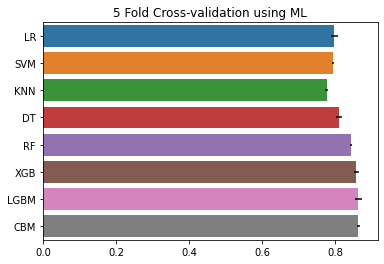

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cv_means = [ x.mean() for x in cv_results ]
cv_std = [ x.std() for x in cv_results ]
cv = {
    'models':names,
    'cv_means':cv_means,
    'cv_std':cv_std
}
sns.barplot(y='models', x='cv_means', 
            data=cv, orient='h', 
            **{'xerr':cv_std})
plt.title("5 Fold Cross-validation using ML")
plt.show()

# 3. Prediction using the best

In [15]:
model = CatBoostClassifier(random_state=0)
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred

Learning rate set to 0.034954
0:	learn: 0.6568756	total: 164ms	remaining: 2m 43s
1:	learn: 0.6199318	total: 177ms	remaining: 1m 28s
2:	learn: 0.5906562	total: 188ms	remaining: 1m 2s
3:	learn: 0.5642466	total: 200ms	remaining: 49.7s
4:	learn: 0.5441430	total: 210ms	remaining: 41.9s
5:	learn: 0.5246658	total: 221ms	remaining: 36.5s
6:	learn: 0.5069239	total: 231ms	remaining: 32.8s
7:	learn: 0.4911121	total: 240ms	remaining: 29.7s
8:	learn: 0.4742474	total: 248ms	remaining: 27.3s
9:	learn: 0.4592078	total: 258ms	remaining: 25.6s
10:	learn: 0.4447123	total: 268ms	remaining: 24.1s
11:	learn: 0.4327032	total: 279ms	remaining: 23s
12:	learn: 0.4234261	total: 290ms	remaining: 22s
13:	learn: 0.4151831	total: 300ms	remaining: 21.1s
14:	learn: 0.4074173	total: 309ms	remaining: 20.3s
15:	learn: 0.3994902	total: 320ms	remaining: 19.7s
16:	learn: 0.3920091	total: 330ms	remaining: 19.1s
17:	learn: 0.3861315	total: 340ms	remaining: 18.5s
18:	learn: 0.3811130	total: 350ms	remaining: 18.1s
19:	learn: 0.

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [16]:
sub = pd.read_csv('dataset/sample_submission.csv')
sub['target'] = pred
sub.to_csv('result/day1.csv', index=False)